<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/main/Borisov%20Vasily/Profpatolog_%2B_Hazard_Risk_%2B_ConfMatrix%2BNewDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Импортируем основные библиотеки
- Загружаем список колонок датасета, которые мы предполагаем использовать для построния модели.
- Список колонок хранится в файле эксель. Файл эксель - на Яндекс Диске.
- Загружаем Датасет с Яндекс Клауда.

In [ ]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
import requests
from urllib.parse import urlencode
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, concatenate, Input, CategoryEncoding, Normalization, Activation, Conv1D
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras import utils
# from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
#from PIL import Image


# читаем список нужных нам полей с ЯД (файл эксель)
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/QWJez3NW1JGGcg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
df_polei = pd.read_excel(download_url)

# gdown.download('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/датасет%20профпатолог%20часть.xlsx', None, quiet=True)
# gdown.download('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%92%D0%B5%D1%81%D1%8C%20%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4.csv', None, quiet=True)
# data = pd.read_excel('E:\ProfPat\датасет%20профпатолог%20часть.xlsx')


In [ ]:
data500 = pd.read_csv('E:\ProfPat\Весь период.csv', sep = ';', on_bad_lines='skip', engine='python' )


- Выводим список колонок, у которых количество значений (nunique()) больше 1 и меньше 35
- В модели это не используется. Только как заготовка для будущего анализа и добавления новых колонок в список анализируемых.

In [ ]:
for (columnName, columnData) in data500.items():
  if columnData.nunique()>1 and columnData.nunique()<35:
    print(columnName + ' /// ' + str(columnData.nunique()))

- Приводим 6 возможных значений категории годности к 3 (в соответствии с ТЗ).
- Например если в датасете категория годности = "ГоденСКоррекциейЗрения", то мы заменяем это значение на "ОграниченноГоден"

In [ ]:
# data500  = data500.copy()

data500=data500.replace('ГоденСКоррекциейЗрения','ОграниченноГоден')
data500=data500.replace('ГоденСКоррекциейСлуха','ОграниченноГоден')
data500=data500.replace('ГоденБезРаботНаВысотах','ОграниченноГоден')
data500=data500.replace('НуждаетсяВДообследованииИЛечении','ВременноНегоден')
data500=data500.replace('Негоден','ВременноНегоден')

In [ ]:
data500.shape

(32686, 289)

In [ ]:
for idx, row in data500.iterrows():
    if not type(row.ВредныеФакторы) is str:
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "янв" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "фев" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "мар" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "апр" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "май" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "июн" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "июл" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "авг" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "сен" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "окт" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "ноя" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)
    elif "дек" in str(row.ВредныеФакторы):
        data500.drop(axis = 0, index = idx ,inplace = True)



"Размножаем" минорные классы (классы с метками "ВременноНегоден" и "ОграниченноГоден")

In [ ]:
for i in range(2):
    data500 = pd.concat([data500,data500.loc[data['ЗаключениеМК']. isin(['ВременноНегоден', 'ОграниченноГоден'])]])


Чистим датафрейм data500
 - удаляя лишние колонки (напомню список нужных колонок храним в эксель файле) и
 - строки, у которых неверно заполнена колонка ЗаключениеМК

In [ ]:
nmp=df_polei['POLE'].tolist()
print(nmp)

for (columnName, columnData) in data500.items():
  if (str(columnName) in nmp)==False:
    data500.pop(columnName)

data500 = data500[data500.ЗаключениеМК.isin(['Годен', 'ВременноНегоден', 'ОграниченноГоден']) == True ]

NameError: name 'df_polei' is not defined

In [ ]:
data500

In [ ]:
data500.to_excel('E:\ProfPat\data2.xlsx')

Формируем списки:
- ListOfColumnNames - наименования колонок
- ListOfColumnValues - значения колонок
- ListOfColumnNames_Lists - значения колонки, в которой содержится список значений (пока это одна колонка - ВредныеФакторы)
- В дальнейшем мы будем использовать эту информацию для токенизации данных нашего датасета

In [ ]:
razdelitel = ","
columnsWithLists = ['ВредныеФакторы']
ListOfColumnNames = []
ListOfColumnValues = []
ListOfColumnNames_Lists = []
for (columnName, columnData) in data500.items():
  ListOfColumnNames.append(columnName)
  if columnName in columnsWithLists:
    print(columnName)
    ListOfColumnValues.append(list(set(razdelitel.join(data500[columnName].tolist()).splitlines()[0].split(','))))
  else:
    ListOfColumnValues.append(list(data500[columnName].dropna().unique().flatten()))

ВредныеФакторы


Приводим наш датасет к векторам

In [ ]:
def get_vector(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  if vectorLen < 25:
    while i < vectorLen:
      if (ListOfColumnValues[columnNumber][i] == row[columnNumber]):
        Null_or_One = 1
      else:
        Null_or_One = 0
      vector = np.hstack([vector, Null_or_One])
      i+=1
  return vector


def get_vector_from_list(row, columnNumber):
  i = 0
  vector = []
  vectorLen = len(ListOfColumnValues[columnNumber])
  rowToList = ((row[columnNumber].split(',')))
  while i < vectorLen:
    if (ListOfColumnValues[columnNumber][i] in rowToList):
      Null_or_One = 1
    else:
      Null_or_One = 0
    vector = np.hstack([vector, Null_or_One])
    i+=1
  return vector


def extract_row_data(row):
  x1_data = []
  x2_data = []
  y_data = []
  for columnName in ListOfColumnNames:
    columnNumber = ListOfColumnNames.index(columnName)
    if columnName == 'ЗаключениеМК':
      y_data = np.hstack([y_data, get_vector(row, columnNumber)])
    elif columnName in columnsWithLists:
      x2_data = np.hstack([x2_data, get_vector_from_list(row, columnNumber)])
    else:
      x1_data = np.hstack([x1_data, get_vector(row, columnNumber)])
  return x1_data, x2_data, y_data



def construct_train_data(row_list):
    x1_data = []
    x2_data = []
    y_data = []
    for row in row_list:
      x1, x2, y = extract_row_data(row)
      x1_data.append(x1)
      x2_data.append(x2)
      y_data.append(y)
    return np.array(x1_data), np.array(x2_data), np.array(y_data)


x1_data500, x2_data500, y_data500 = construct_train_data(data500.values)

Импортируем модель FastText. Модель большая (> 7 Гб), поэтому делал все локально

In [ ]:
import fasttext
ft = fasttext.load_model('E:\cc.ru.300.bin')

Преобразуем профессию сотрудника в вектор, используя fasttext

In [ ]:
x3_data500 = []
for row in data500.values:
  wordVector = ft.get_word_vector(str(row[1]))
  x3_data500.append(wordVector)
x3_data500 = np.array(x3_data500)

In [ ]:
# Разбиение наборов на общую и тестовую выборки
# x1_all, x1_test, x2_all, x2_test, x3_all, x3_test, y_all, y_test = train_test_split(
#                                                 x1_data500,
#                                                 x2_data500,
#                                                 x3_data500,
#                                                 y_data500,
#                                                 test_size=0.1,
#                                                 shuffle=True,
#                                                 random_state = 6)

# # Разбиение общей выборки на обучающую и проверочную
# x1_train, x1_val, x2_train, x2_val, x3_train, x3_val, y_train, y_val = train_test_split(
#                                                   x1_all,
#                                                   x2_all,
#                                                   x3_all,
#                                                   y_all,
#                                                   test_size=0.1,
#                                                   shuffle=True,
#                                                   random_state = 6)

NameError: name 'x1_data' is not defined

Запускаем модель

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_chekpoint = ModelCheckpoint("MyModel_weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                                SaveBestOnly = True,
                                monitor = 'val_accuracy',
                                mode = 'max',
                                verbose = 1)

In [ ]:



%matplotlib inline

# Разбиение наборов на общую и тестовую выборки
x1_all, x1_test, x2_all, x2_test, x3_all, x3_test, y_all, y_test = train_test_split(
                                                x1_data500,
                                                x2_data500,
                                                x3_data500,
                                                y_data500,
                                                test_size=0.1,
                                                shuffle=True,
                                                random_state = 6)

# Разбиение общей выборки на обучающую и проверочную
x1_train, x1_val, x2_train, x2_val, x3_train, x3_val, y_train, y_val = train_test_split(
                                                  x1_all,
                                                  x2_all,
                                                  x3_all,
                                                  y_all,
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state = 6)


input1 = Input((x1_train.shape[1],))
input2 = Input((x2_train.shape[1],))
input3 = Input((x3_train.shape[1],))

x1 = input1                               # Ветка 1
x1 = Normalization()(x1)
x1 = Dense(256, activation="relu")(x1)
x1 = Dropout(0.1)(x1)                   #ddfds удал
x1 = Activation('relu')(x1)
x1 = Dense(32, activation="relu")(x1)
x1 = Activation('relu')(x1)
x1 = Dense(3, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu")(x2)
# x2 = Dropout(0.15)(x2)
x2 = Dense(500, activation="relu")(x2)

x3 = input3                               # Ветка 3
x3 = Dense(50, activation="relu")(x3)
x3 = Dense(500, activation="relu")(x3)

x23 = concatenate([x2, x3])             # Объединение 3 веток
x23 = Dense(15, activation='relu')(x23) # Промежуточный слой
x = concatenate([x1, x23])              # Объединение 3 веток




x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
#x = keras.constraints.MinMaxNorm(min_value=0.0, max_value=1.0, rate=1.0, axis=0)(x)
x = Dense(3, activation='softmax')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2, input3), x)

# model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['mae'])
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_final.fit([x1_train, x2_train, x3_train],
                           y_train,
                           batch_size=256,
                           epochs=150,
                           validation_split=0.15,
                        #    callbacks = [model_chekpoint],
                           verbose=1)

Epoch 1/150
48/48 [==============================] - 16s 125ms/step - loss: 0.5545 - accuracy: 0.9048 - val_loss: 0.2590 - val_accuracy: 0.9388
Epoch 2/150
48/48 [==============================] - 5s 101ms/step - loss: 0.2564 - accuracy: 0.9339 - val_loss: 0.2305 - val_accuracy: 0.9388
Epoch 3/150
48/48 [==============================] - 5s 97ms/step - loss: 0.2360 - accuracy: 0.9339 - val_loss: 0.2232 - val_accuracy: 0.9388
Epoch 4/150
48/48 [==============================] - 5s 101ms/step - loss: 0.2248 - accuracy: 0.9339 - val_loss: 0.2157 - val_accuracy: 0.9388
Epoch 5/150
48/48 [==============================] - 5s 97ms/step - loss: 0.2187 - accuracy: 0.9339 - val_loss: 0.2168 - val_accuracy: 0.9388
Epoch 6/150
48/48 [==============================] - 5s 97ms/step - loss: 0.2130 - accuracy: 0.9339 - val_loss: 0.2154 - val_accuracy: 0.9388
Epoch 7/150
48/48 [==============================] - 5s 101ms/step - loss: 0.2077 - accuracy: 0.9339 - val_loss: 0.2190 - val_accuracy: 0.9388
E

Рисуем график модели

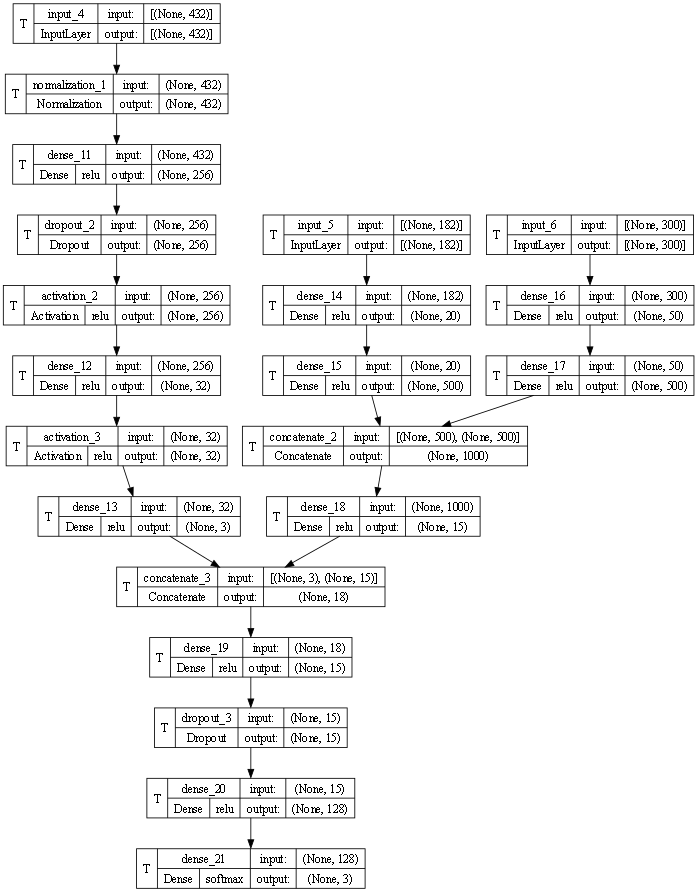

In [ ]:
utils.plot_model(model_final, show_shapes=True, show_layer_names=True, dpi=60, show_layer_activations=True, show_trainable=True)

In [ ]:
x1_val.shape[1]

432

50/50 [==============================] - 1s 12ms/step - loss: 0.4972 - accuracy: 0.9155


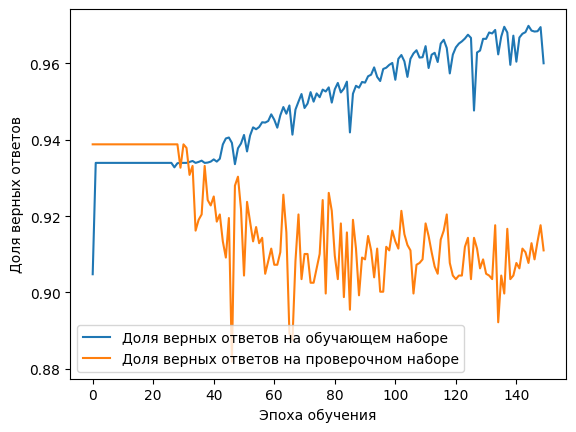

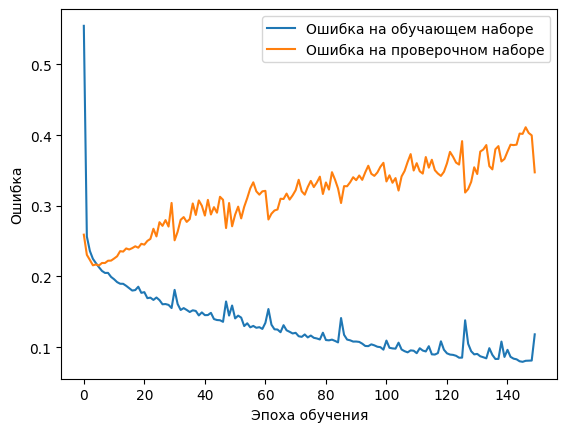

In [ ]:
from tensorflow.keras.models import load_model
# model_final = load_model('MyModel_weights.19-0.14.hdf5')
scores = model_final.evaluate([x1_test, x2_test, x3_test],
                        y_test,
                        verbose=1
                        )
scores2 = model_final.evaluate([x1_val, x2_val, x3_val],
                        y_val,
                        verbose=1
                        )
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()


plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')

plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

55/55 [==============================] - 1s 10ms/step


array([[1581,   61,    4],
       [  53,   46,    0],
       [   2,    0,    1]], dtype=int64)

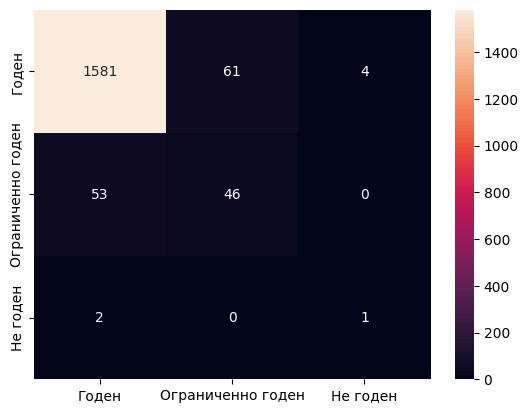

In [ ]:
y_pred = model_final.predict([x1_test, x2_test, x3_test])

y_pred2=np.argmax(y_pred, axis=1)
y_test2=np.argmax(y_test, axis=1)
cm_data = confusion_matrix(y_test2, y_pred2)


sns.heatmap(cm_data,
            annot=True,
            fmt='g',
            xticklabels=['Годен', 'Ограниченно годен', 'Не годен'],
            yticklabels=['Годен', 'Ограниченно годен', 'Не годен'])

cm_data